In [1]:
# All imports should be in first cell
import cartopy
import GMesh
import imp
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Open and read a topographic dataset

Open a topography dataset, check that the topography is on a uniform grid.

In [2]:
# URL of topographic data, names of longitude, latitude and elevation variables
# url,vx,vy,ve = '/archive/gold/datasets/topography/GEBCO_08_v1.nc','longitude','latitude','depth'
url,vx,vy,ve = '/net2/nnz/thin-wall-topography/python/workdir/GEBCO_2014_2D.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/MED_GEBCO_30sec.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO1/.z_bedrock/dods','lon','lat','z_bedrock'
topo_data = netCDF4.Dataset(url)

# Read coordinates of topography
topo_lons = np.array( topo_data.variables[vx][:] )
topo_lats = np.array( topo_data.variables[vy][:] )
topo_elvs = np.array( topo_data.variables[ve][:,:] )

print('topography grid array shapes: ' , topo_lons.shape,topo_lats.shape)
print('topography longitude range:',topo_lons.min(),topo_lons.max())
print('topography latitude range:',topo_lats.min(),topo_lats.max())

print('Is mesh uniform?', GMesh.is_mesh_uniform( topo_lons, topo_lats ) )

topography grid array shapes:  (43200,) (21600,)
topography longitude range: -179.995833333 179.995833333
topography latitude range: -89.9958333333 89.9958333333
Is mesh uniform? True


In [3]:
#Translate topo data to start at target_mesh.lon[0]
topo_lons = np.roll(topo_lons,14400,axis=0) #Roll GEBCO longitude to right. 14400 was a lucky guess that checked out!
topo_lons = np.where(topo_lons>60 , topo_lons-360, topo_lons) #Rename (0,60) as (-300,-180) 
topo_elvs = np.roll(topo_elvs,14400,axis=1) #Roll GEBCO depth to the right by the same amount.


# Read a target grid

In [4]:
#Read in Mercator grid for 1/8 degree model
targ_grid =  netCDF4.Dataset('/net2/nnz/grid_generation/workdir/grid_OM4p125_new/tripolar_disp_res8.ncBP.nc')
targ_lon = np.array(targ_grid.variables['x'])
targ_lat = np.array(targ_grid.variables['y'])

## Partition the Target grid into non-intersecting blocks
 The 1/8 degree grid is too big to be handled in one go (my 64G machine runs out of memory and starts  to swap rendering the machine useless). Hence, we break the target to pieces and handle them one at a time. 

Future enhancement: 

    Make the block shape arbitrary rather than 2x2
    Delegate these blocks to GPU tasks.

In [5]:
#This works only if the target mesh is "regular"! Niki: Find the mathematical buzzword for "regular"!!
#Is this a regular mesh?
#targ_lon[1,:] - targ_lon[0,:]

def break_array_to_blocks(a,xb=4,yb=1):
    a_win = []
    if(xb == 4 and yb ==1):
        i1 = a.shape[1]//xb
        i2 = 2*i1
        i3 = 3*i1
        i4 = a.shape[1]
        
        j1 = a.shape[0]//yb
        a_win.append(a[0:j1,0:i1])
        a_win.append(a[0:j1,i1:i2])
        a_win.append(a[0:j1,i2:i3])
        a_win.append(a[0:j1,i3:i4])
        return a_win
    else:    
        raise Exception('This rotuine can only make 2x2 blocks!')
        ##Niki: Implement a better algo and lift this restriction

def undo_break_array_to_blocks(a,xb=4,yb=1):    
    if(xb == 4 and yb ==1):        
        ao = np.append(a[0],a[1],axis=1)
        ao = np.append(ao,a[2],axis=1)
        ao = np.append(ao,a[3],axis=1)
        return ao
    else:    
        raise Exception('This rotuine can only make 2x2 blocks!')
        ##Niki: Implement a better algo and lift this restriction
        
def write_topog(h,fnam=None,format='NETCDF3_CLASSIC',description=None,history=None,source=None,no_changing_meta=None):
    import netCDF4 as nc

    if fnam is None:
      fnam='topog.nc'
    fout=nc.Dataset(fnam,'w',format=format)

    ny=h.shape[0]; nx=h.shape[1]
    print ('Writing netcdf file with ny,nx= ',ny,nx)

    ny=fout.createDimension('ny',ny)
    nx=fout.createDimension('nx',nx)
    string=fout.createDimension('string',255)    
    tile=fout.createVariable('tile','S1',('string'))
    height=fout.createVariable('height','f8',('ny','nx'))
    height.units='meters'
    height[:]=h
    #global attributes
    if(not no_changing_meta):
        fout.history = history
        fout.description = description
        fout.source =  source

    fout.sync()
    fout.close()
        

In [6]:
xb=4
yb=1
lons=break_array_to_blocks(targ_lon,xb,yb)
lats=break_array_to_blocks(targ_lat,xb,yb)

targ_lon.shape,lons[0].shape,lats[0].shape

((948, 5761), (948, 1440), (948, 1440))

In [7]:
##Test that we can reconstruct the array from blocks
#test_blk = []
#for p in range(0,4):
#    test_blk.append(np.zeros(lons[p].shape) + p)
#
#test_data = undo_break_array_to_blocks(test_blk,4,1)
#test_data.shape
#plt.pcolormesh(test_data);

In [8]:
#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
imp.reload(GMesh)

#plt.figure(figsize=(10,10))
#ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_latitude=90))
#ax.set_global()
#ax.stock_img()
#ax.coastlines()
#ax.gridlines()

Hlist=[]

#for b in range(0,xb):
for b in range(0,1):
    lon = lons[b]
    lat = lats[b]
    target_mesh = GMesh.GMesh( lon=lon, lat=lat )
    print( target_mesh )
    #target_mesh.plot(ax,subsample=100, transform=cartopy.crs.Geodetic());

    # Indices in topographic data
    ti,tj = target_mesh.find_nn_uniform_source( topo_lons, topo_lats )

    #Sample every other source points for demo performance 
    #Niki: Try to remove this restriction
    tis,tjs = slice(ti.min(), ti.max()+1,2), slice(tj.min(), tj.max()+1,2)
    print('Slices:', tis, tjs )

    # Read elevation data
    topo_elv = topo_elvs[tjs,tis]
    # Extract appropriate coordinates
    topo_lon = topo_lons[tis]
    topo_lat = topo_lats[tjs]

    print('Topo shape:', topo_elv.shape)
    print('topography longitude range:',topo_lon.min(),topo_lon.max())
    print('topography latitude  range:',topo_lat.min(),topo_lat.max())

    print("Target     longitude range:", lon.min(),lon.max())
    print("Target     latitude  range:", lat.min(),lat.max())
    
    #Refine
    print("Refining the target to hit all source points ...")
    Glist = target_mesh.refine_loop( topo_lon, topo_lat , max_mb=8000)
    
    hits = Glist[-1].source_hits( topo_lon, topo_lat )
    print("non-hit ratio: ",hits.size-hits.sum().astype(int)," / ",hits.size)

    #Sample
    print("Sampling the source points on target mesh ...")
    Glist[-1].sample_source_data_on_target_mesh(topo_lon,topo_lat,topo_elv)
  
    #Coarsen back to the original taget grid
    print("Coarsening back to the original taget grid ...")
    for i in reversed(range(1,len(Glist))):   # 1, makes it stop at element 1 rather than 0
        Glist[i].coarsenby2_v0(Glist[i-1])

    Hlist.append(Glist[0].height)
    print("Writing ...")
    filename = 'topog_refsamp_BP.nc'+str(b) 
    write_topog(Glist[0].height,fnam=filename,no_changing_meta=True)
    print("haigts shape:", lons[b].shape,Hlist[b].shape)

<GMesh nj:947 ni:1439 shape:(947,1439)>
Slices: slice(0, 10793, 2) slice(18483, 21599, 2)
Topo shape: (1558, 5397)
topography longitude range: -299.995833333 -210.0625
topography latitude  range: 64.0291666667 89.9791666667
Target     longitude range: -300.0 -210.0625
Target     latitude  range: 64.0316327998 89.9855889081
Refining the target to hit all source points ...
<GMesh nj:947 ni:1439 shape:(947,1439)> Hit 1311496 out of 8408526 cells (20.7937 Mb)
<GMesh nj:1894 ni:2878 shape:(1894,2878)> Hit 4003252 out of 8408526 cells (83.1746 Mb)
<GMesh nj:3788 ni:5756 shape:(3788,5756)> Hit 7242039 out of 8408526 cells (332.6985 Mb)
<GMesh nj:7576 ni:11512 shape:(7576,11512)> Hit 8105389 out of 8408526 cells (1330.7939 Mb)
<GMesh nj:15152 ni:23024 shape:(15152,23024)> Hit 8347566 out of 8408526 cells (5323.1758 Mb)
non-hit ratio:  60960  /  8408526
Sampling the source points on target mesh ...
Coarsening back to the original taget grid ...
Writing ...
Writing netcdf file with ny,nx=  948 1

In [13]:
height_refsamp = undo_break_array_to_blocks(Hlist,4,1)
targ_lon.shape,height_refsamp.shape

((948, 5761), (948, 5761))

In [27]:
filename = 'topog_refsamp_BP.nc' 
write_topog(height_refsamp,fnam=filename,no_changing_meta=True)


Writing netcdf file with ny,nx=  948 5761


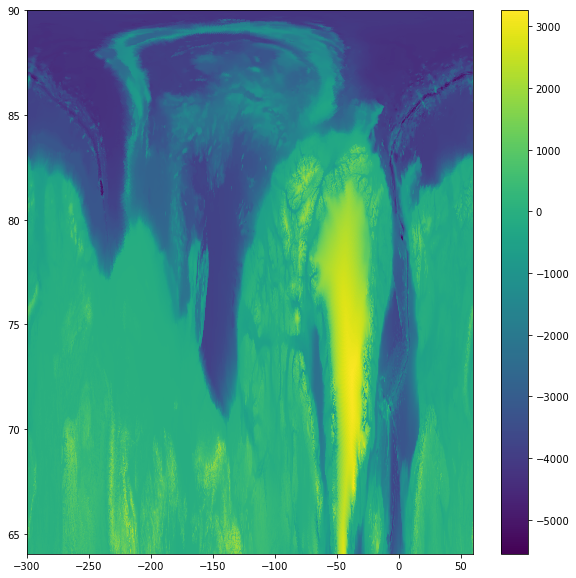

In [15]:
plt.figure(figsize=(10,10))
plt.pcolormesh(targ_lon,targ_lat,height_refsamp);plt.colorbar();

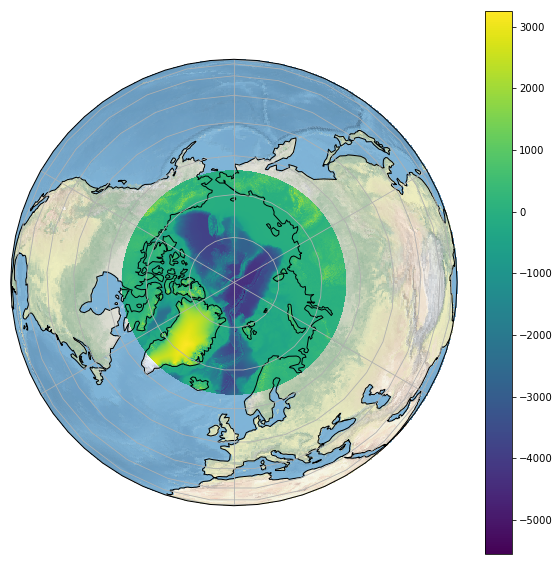

In [25]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_latitude=90))
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.gridlines()
im = ax.pcolormesh(targ_lon,targ_lat,height_refsamp, transform=cartopy.crs.PlateCarree())
plt.colorbar(im,ax=ax);


MemoryError: 

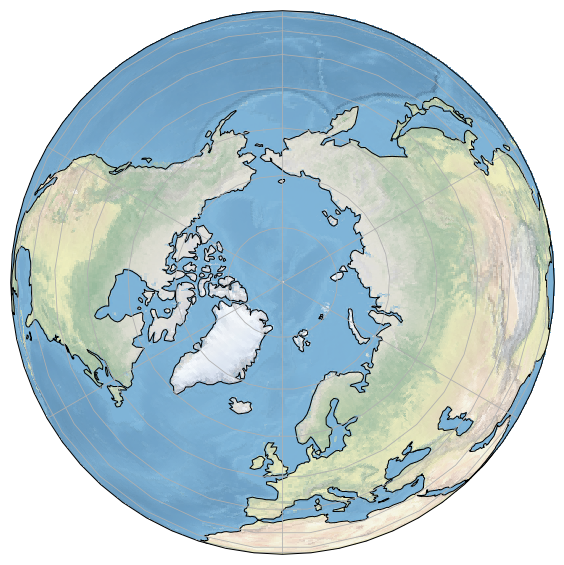

In [26]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_latitude=90))
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.gridlines()
im = ax.pcolormesh(topo_lons,topo_lats,topo_elvs, transform=cartopy.crs.PlateCarree())
plt.colorbar(im,ax=ax);
